## Библиотеки и определение функций

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import random as rm
import numpy as np
from numpy.random import default_rng
import pandas as pd
import time

rng = default_rng()

In [2]:
def str2int_arr(str):
    return np.array([float(i) for i in str], dtype="byte")

def graph_from_file(file):
    w = []
    with open(file, "r") as f:
        for line in f:
            arr = line.split()
            map(int, arr)
            w.append(str2int_arr(arr))
    return nx.from_numpy_matrix(np.array(w))

def graph_from_dimacs(file):
    G = nx.Graph()
    with open(file, "r") as f:
        for line in f:
            buff = line.split()
            if buff[0]=="p":
                G.add_nodes_from([i for i in range(1, int(buff[2])+1 )])
                break
        for line in f:
            edge = line.split()
            G.add_edge(int(edge[1]), int(edge[2]))
    return G

In [3]:
def f_activations(x):
    return 1 / ( 1 + np.exp(x) )

def f_act01(x):
    return 1 if x > 0 else 0

def energy(X, W, B=1):
    sum = 0  # количество рёбер
    n = np.sum(X)  # количество вершин
    full_eges = -n*(n-1)//2# количество ребер в полном графе на n вершин
    
    for i in range(len(X)):
        for j in range(i, len(X)):
            sum += W[i, j]*X[i]*X[j]

    return n + (full_eges + sum)*2*B, n, full_eges+sum 
    
def multy_mutation(individual):
    n = individual.size
    num_mutation=n//3
    
    for _ in range(num_mutation):
        individual[np.random.randint(0, n)] ^= 1
    return individual

def NN(W, X ,B=0.5, times=1000, unchanged_threshold=20):
    N = X.size
    h_i = 1
    
    energies = np.array([], dtype="int")
    xs = []
    max_en = 0
    max_node = 0
    missing_edges = 0
    unchanged_count = 0
    iter = 0
    

    for iteration in range(times):
        
        iter += 1
        neuron_nums = rm.sample(range(1, N), 5)
        for neuron in neuron_nums:
            X_next = 0
            for j in range(N):
                X_next += (1-W[neuron, j])*X[j]
            X_next = f_act01(X_next*(-B) + h_i)

            X[neuron] = X_next

        if iteration > times*0.8:
            
            ener = energy(X, W, B)
            energies = np.append(energies, ener[0])
            xs.append(X.copy())
            
            if max_en == ener[0]:
                unchanged_count += 1
                if unchanged_count >= unchanged_threshold:
                    break
            else:
                unchanged_count = 0
                
            if max_en < ener[0]:
                max_en = ener[0]
                max_node = ener[1]
                missing_edges = ener[2]
        
            
            
            # print(X)
        
    return X, energies, xs, max_en, max_node, missing_edges#, iter

## Загрузка графа

In [72]:
#G = graph_from_file("graph_examples/34_14")
G = graph_from_dimacs("data/DIMACS_subset_ascii/C1000.9.clq")
W = nx.adjacency_matrix(G).todense()
# nx.draw(G, with_labels=True)

C:\Users\arkad\AppData\Local\Temp\ipykernel_988\1190627997.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


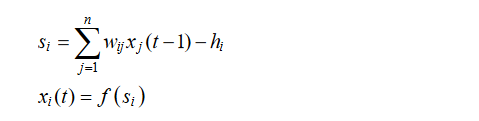

## Запуск алгоритма

In [19]:
X = np.ones(G.number_of_nodes(), dtype="byte")
X, energies, xs, max_en, max_node, missing_edges = NN(W, X, 0.6, 1000)

In [20]:
print(max_en, max_node, missing_edges)

30.8 32 -1


In [17]:
energies[-1]

33.2

## NN

In [ ]:
G = graph_from_dimacs("data/DIMACS_subset_ascii/C1000.9.clq")
W = nx.adjacency_matrix(G).todense()

In [4]:
df = pd.DataFrame(columns=['hi', 'number of iterations', 'number of runs', 'best score',"average score" , 'time'])

In [5]:
#----------Hyperparameters----------
hi = 0.6
iterations = 1500
number_of_runs = 5
#-----------#-----------#----------- 

In [6]:
def mult_hop(num_parameter, arr, hi, iterations, number_of_runs, df):
    for i in arr:
        
        start_time = time.time()
        input = [hi, iterations, number_of_runs]
        input[num_parameter] = i 
        result = 0
        avg = 0
        
        for _ in range(input[2]):
            X = np.ones(G.number_of_nodes(), dtype="byte")
            X, energies, xs, max_en, max_node, missing_edges = NN(W, X, input[0], input[1])
            
            out_V = max_node+missing_edges
            avg += out_V
            result = max(result, out_V)

        avg = avg / input[2]
        df.loc[len(df)] = [*input, result, avg, (time.time() - start_time)]

In [76]:
hi_arr = [0.4, 0.5, 0.6, 0.65, 0.7, 0.8]
mult_hop(0, hi_arr, hi, iterations, number_of_runs, df)

In [77]:
iterations_arr = [250, 500, 1000, 2000, 5000]
mult_hop(1, iterations_arr, hi, iterations, number_of_runs, df)

In [78]:
nor_arr = [2, 3, 5, 10, 15, 25]
mult_hop(2, nor_arr, hi, iterations, number_of_runs, df)

In [79]:
df

,hi,number of iterations,number of runs,best score,average score,time
0,0.40,1500.0,5.0,43.0,39.200000,523.530536
1,0.50,1500.0,5.0,46.0,43.600000,71.887514
2,0.60,1500.0,5.0,48.0,46.800000,593.705671
3,0.65,1500.0,5.0,48.0,46.200000,473.772111
4,0.70,1500.0,5.0,51.0,44.800000,430.629276
5,0.80,1500.0,5.0,45.0,42.200000,801.971388
6,0.60,250.0,5.0,0.0,0.000000,98.777474
7,0.60,500.0,5.0,0.0,0.000000,190.931362
8,0.60,1000.0,5.0,39.0,32.400000,398.510815
9,0.60,2000.0,5.0,50.0,48.800000,574.751562


## График энергии от hi (переделать)

## Проверка на графах из DIMACS

In [7]:
DIMACS = ["C125.9",
        "C250.9",
        "C500.9",
        "C1000.9",
        "C2000.9",
        #"DSJC1000_5",
        #"DSJC500_5",
        "C2000.5",
        "C4000.5",
        "MANN_a27",
        "MANN_a45",
        #"MANN_a81",
        "brock200_2",
        "brock200_4",
        "brock400_2",
        "brock400_4",
        "brock800_2",
        "brock800_4",
        "gen200_p0.9_44",
        "gen200_p0.9_55",
        "gen400_p0.9_55",
        "gen400_p0.9_65",
        "gen400_p0.9_75",
        "hamming10-4",
        "hamming8-4",
        "keller4",
        "keller5",
        #"keller6",
        "p_hat300-1",
        "p_hat300-2",
        "p_hat300-3",
        "p_hat700-1",
        "p_hat700-2",
        "p_hat700-3",
        "p_hat1500-1",
        "p_hat1500-2",
        "p_hat1500-3"]

In [8]:
df_dim = pd.DataFrame(columns=["Benchmark", "NN 𝝎(G)", "NN Time [s]"])

In [11]:
for graph_number in range(len(DIMACS)):
    G = graph_from_dimacs("data/DIMACS_subset_ascii/"+ DIMACS[graph_number] +".clq")
    W = nx.adjacency_matrix(G).todense()
    
    start_time = time.time()
    X = np.ones(G.number_of_nodes(), dtype="byte")
    X, energies, xs, max_en, max_node, missing_edges = NN(W, X, 0.6, 10000, unchanged_threshold=50)
    
    df_dim.loc[len(df_dim)] = [DIMACS[graph_number], max_node+missing_edges, (time.time() - start_time)]
    
    print("done ", graph_number)

C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  0


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  1


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  2


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  3


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  4


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  5


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  6


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  7


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  8


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  9


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  10


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  11


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  12


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  13


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  14


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  15


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  16


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  17


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  18


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  19


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  20


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  21


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  22


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  23


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  24


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  25


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  26


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  27


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  28


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  29


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  30


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  31


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2912086180.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  32


In [15]:
df_dim[33:]

,Benchmark,NN 𝝎(G),NN Time [s]
33,C125.9,34,21.027260
34,C250.9,40,28.872139
35,C500.9,50,108.862094
36,C1000.9,58,179.961964
37,C2000.9,64,146.878269
38,C2000.5,13,1200.860273
39,C4000.5,9,880.325724
40,MANN_a27,120,131.972855
41,MANN_a45,332,944.187472
42,brock200_2,8,14.132812


## GA -> NN

In [16]:
df = pd.DataFrame(columns=['hi', 'number of iterations', 'number of runs', 'best score',"average score" , 'time'])

In [23]:
import pickle
with open('data/graphFromGaToHop/C500.9.pkl', 'rb') as input:
    pop_ga = pickle.load(input)
print(len(pop_ga))

40


In [ ]:
start_time = time.time()
out_energ = []
result = 0
avg = 0

for x in pop_ga:
    X = x
    X, energies, xs, max_en, max_node, missing_edges = NN(W, X, hi, iterations)
    out_V = max_node+missing_edges
    avg += out_V
    result = max(result, out_V)

avg = avg / len(pop_ga)
df.loc[len(df)] = [hi, iterations, len(pop_ga), result, avg, (time.time() - start_time)]

In [ ]:
df

,hi,number of iterations,number of runs,best score,average score,time
0,0.6,1500.0,40.0,37.0,34.825,303.146555


### GA -> NN DIMACS

In [25]:
from os import listdir
from os.path import isfile, join
ga_dimacs = [f for f in listdir("data/graphFromGaToHop") if isfile(join("data/graphFromGaToHop", f))]

In [45]:
df_dim = pd.DataFrame(columns=["Benchmark", "NN 𝝎(G)", "NN Time [s]"])

In [46]:
for graph_number in range(len(DIMACS)):
    G = graph_from_dimacs("data/DIMACS_subset_ascii/"+ DIMACS[graph_number] +".clq")
    W = nx.adjacency_matrix(G).todense()
    with open('data/graphFromGaToHop/' + DIMACS[graph_number] + '.pkl', 'rb') as input:
        pop_ga = pickle.load(input)
    
    
    start_time = time.time()
    # X = np.ones(G.number_of_nodes(), dtype="byte")
    X = pop_ga[0]
    X, energies, xs, max_en, max_node, missing_edges = NN(W, X, 0.6, 4000, unchanged_threshold=40)
    
    df_dim.loc[len(df_dim)] = [DIMACS[graph_number], max_node+missing_edges, (time.time() - start_time)]
    
    print("done ", graph_number)

C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  0


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  1


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  2


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  3


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  4


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  5


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  6


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  7


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  8


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  9


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  10


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  11


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  12


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  13


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  14


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  15


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  16


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  17


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  18


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  19


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  20


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  21


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  22


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  23


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  24


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  25


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  26


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  27


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  28


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  29


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  30


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  31


C:\Users\arkad\AppData\Local\Temp\ipykernel_14688\2448206681.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


done  32


In [47]:
df_dim

,Benchmark,NN 𝝎(G),NN Time [s]
0,C125.9,34,7.605123
1,C250.9,43,35.509870
2,C500.9,49,134.981685
3,C1000.9,55,57.221195
4,C2000.9,58,1111.331763
5,C2000.5,12,144.178597
6,C4000.5,11,1301.870866
7,MANN_a27,117,87.610566
8,MANN_a45,331,510.951844
9,brock200_2,9,26.227097
